## Praca domowa 2, WUM 
* Autor: Piotr Nawrot
* Data: 26.03.2021

## Do rozwiązania zadania 2 używam tych samych danych co w zadaniu 1 więc pozwoliłem sobie zostawić już poczynione obserwacje i opisy. Konkretnie rozwiązane podpunkty zadania 2 znajdują się na dole, po części z zadania 1.

# Problem Portugalskiego banku i oferty lokat terminowych

* Celem zadania jest zbudowanie modelu, który na podstawie historycznych danych określi czy klient zechce założyć lokatę w naszym portugalskim banku.
* Od predykcji modelu będzie zależała strategia banku, na podstawie prawdopodobieństwa skorzystania z oferty przez potencjalnego klienta pracownicy banku będą decydować czy warto się z nim kontaktować.
    * Z tego powodu będziemy optymalizować metrykę ROC_AUC
* Dane użyte w poniższym notebooku są oparte o https://archive.ics.uci.edu/ml/datasets/bank+marketing 
    * Jedyna modyfikacja danych polega na tym, że zostało usunięte kilka kolumn celem utrudnienia zadania - w danych wyjściowo był dosyć duży leak, a mianowicie kolumna z czasem ostatniej rozmowy banku z klientem. 
    * Czas tej rozmowy miał bardzo dużą korelację z faktem założenia lokaty. 

## Wczytanie danych i zaimportowanie bibliotek, nic ciekawego

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd
import numpy as np
from collections import defaultdict

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
full_dataset = pd.read_csv('bank-classification.csv')
print(full_dataset.shape)
data_len = full_dataset.shape[0]

(41188, 15)


## Opis danych

* birth_date - self-explainable 
* job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired', 'self- employed','services','student','technician','unemployed','unknown') 
* marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) 
* education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') 
* default: has credit in default? (categorical: 'no','yes','unknown') 
* housing: has housing loan? (categorical: 'no','yes','unknown') 
* loan: has personal loan? (categorical: 'no','yes','unknown') 

* contact_date: ostatnia data kontaktu 
* contact: contact communication type (categorical: 'cellular','telephone') 

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted) 
* previous: number of contacts performed before this campaign and for this client (numeric) 
* poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') 

In [3]:
full_dataset.head()

,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
0,1,1952-03-23,housemaid,married,basic.4y,no,no,no,2008-05-12,telephone,1,999,0,nonexistent,no
1,2,1951-03-24,services,married,high.school,unknown,no,no,2008-05-26,telephone,1,999,0,nonexistent,unknown
2,3,1971-05-19,services,married,high.school,no,yes,no,2008-05-05,telephone,1,999,0,nonexistent,no
3,4,1968-01-24,admin.,married,basic.6y,no,no,no,2008-05-19,telephone,1,999,0,nonexistent,unknown
4,5,1952-05-11,services,married,high.school,no,no,yes,2008-05-19,telephone,1,999,0,nonexistent,unknown


### Data anylysis

Ciekawe obserwacje:
* Uczniowie i emeryci zakładają stosunkowo więcej lokat niż pozostali, ma to trochę sensu, Ci ludzie nie mają kredytów i losowych wydatków
* Osoby w związkach zakładają ciut mniej lokat niż single, możliwe, że wynika także z kredytów/wydatków na dzieci
* Jeśli ktoś ma problemy ze spłatą kredytu to raczej nie zakłada lokaty, to może być ważny czynnik
* Jeśli kontaktujemy się z kimś przez telefon komórkowy a nie stacjonarny to mamy większą szansę na wzięcie kredytu
* Jeśli ktoś wcześniej korzystał z usług banku, to na pewno warto do niego zadzwonić

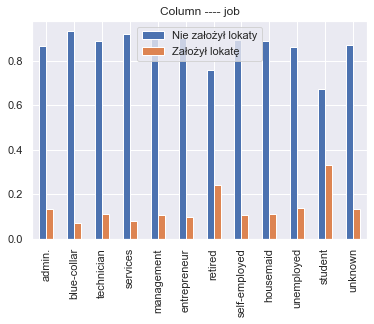

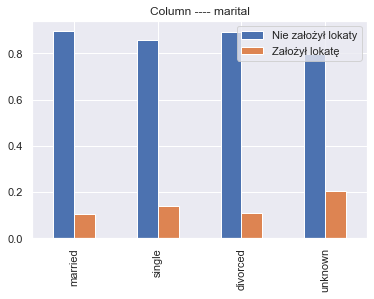

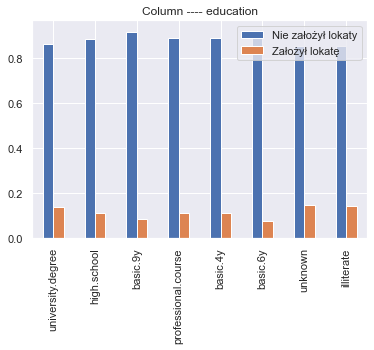

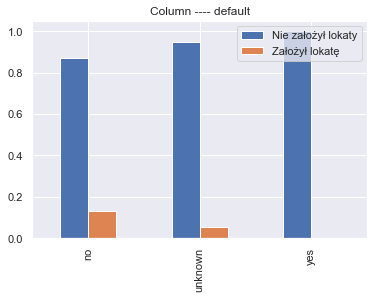

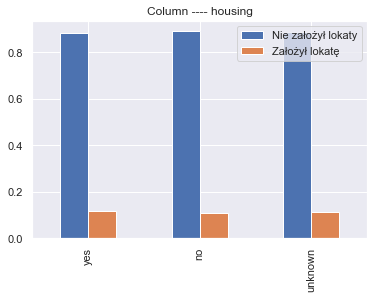

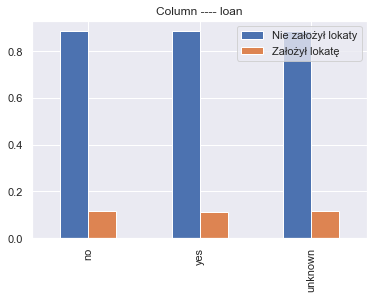

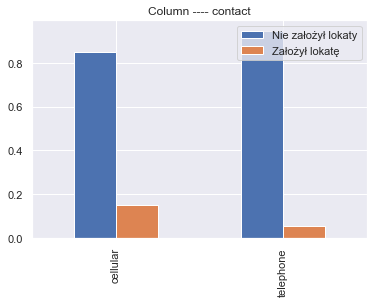

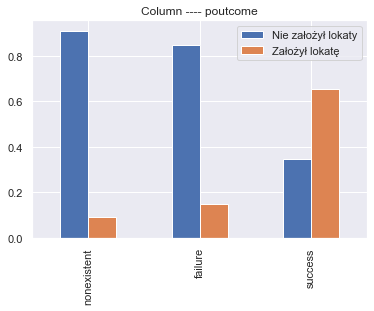

In [4]:
data = full_dataset.copy()

def plot_bar(column):
    df = pd.DataFrame()
    df['Nie założył lokaty'] = data[data['y'] == 'no'][column].value_counts()
    df['Założył lokatę'] = data[data['y'] == 'yes'][column].value_counts()
    df = df.div(df.sum(axis=1), axis=0)
    df.plot.bar(title = 'Column ---- {}'.format(column))
    plt.show()

for feature in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']:
    plot_bar(feature)

* Spójrzmy jeszcze na wiek, skoro wcześniej zauważyliśmy że emeryci i studenci częściej biorą kredyty to powinno to się też potwierdzić pod kątem wieku
    * I rzeczywiście, potwierdza się:
        * Dla osób poniżej 19 roku życia i po 58 wskaźnik wzięcia lokaty jest znacząco wyższy na poziomie >35% podczas gdy dla osób w średnim wieku wynik wacha się w okolicach 10-15%

In [5]:
data = full_dataset.copy()
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['contact_date'] = pd.to_datetime(data['contact_date'])
age = (data['contact_date'] - data['birth_date']).dt.days // 365

l = 0

def count_yes_ratio(mask):
    data_subset = data[mask]
    yes = (data_subset.y == 'yes').sum()
    no = (data_subset.y == 'no').sum()
    return yes / (yes + no)

for idx, quantile in enumerate([0.002, 0.03, 0.1, 0.4, 0.7, 0.96, 1]):
    r = int(age.quantile(quantile))
    mask = ((age > l) & (age <= r))
    score = count_yes_ratio(mask)
    print(f'Quantile of {quantile} equals to: {age.quantile(quantile)}. \n'  
            f'Score for this group eqauls to: {score} \n' + 
            f'Group contains of {mask.sum()} members. \n')
    l = r

Quantile of 0.002 equals to: 19.0. 
Score for this group eqauls to: 0.41818181818181815 
Group contains of 107 members. 

Quantile of 0.03 equals to: 24.0. 
Score for this group eqauls to: 0.1987281399046105 
Group contains of 1249 members. 

Quantile of 0.1 equals to: 28.0. 
Score for this group eqauls to: 0.1480637813211845 
Group contains of 3534 members. 

Quantile of 0.4 equals to: 35.0. 
Score for this group eqauls to: 0.10900095754867539 
Group contains of 12456 members. 

Quantile of 0.7 equals to: 45.0. 
Score for this group eqauls to: 0.0866067203028869 
Group contains of 12484 members. 

Quantile of 0.96 equals to: 58.0. 
Score for this group eqauls to: 0.09528565721134638 
Group contains of 9902 members. 

Quantile of 1 equals to: 97.0. 
Score for this group eqauls to: 0.3516042780748663 
Group contains of 1456 members. 



### Data preprocessing

* Pomimo tego, że poniższy data processing jest ogromny, to nie ma tutaj nic specjalnie wartego uwagi
* Wyciągnałem kilka featurów z daty kontaktu, takie jak miesiąc, rok, dzień miesiąca i tygodnia
* Wyciągnąłem wiek klienta
* Zmapowałem kategorie na inty żeby były odpowiednim wejściem do modelu w sposób mniej lub bardziej arbitralny

In [6]:
data = full_dataset.copy()
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['contact_date'] = pd.to_datetime(data['contact_date'])

def calculate_age(data):
    data['age'] = (data['contact_date'] - data['birth_date']).dt.days // 365
    data['age'] = pd.qcut(data['age'], 10, labels=False, duplicates = 'drop')
    return data

data = calculate_age(data)

data['contact_year'] = data.contact_date.dt.year
data['contact_month'] = data.contact_date.dt.month
data['contact_day_of_month'] = data.contact_date.dt.day
data['contact_day_of_week'] = data.contact_date.dt.dayofweek

data['job_cat'] = data['job'].map({'admin.': 8,
                                    'blue-collar': 0,
                                    'entrepreneur': 2,
                                    'housemaid': 5,
                                    'management': 3,
                                    'retired': 10,
                                    'self-employed': 4,
                                    'services': 1,
                                    'student': 11,
                                    'technician': 6,
                                    'unemployed': 9,
                                    'unknown': 7}).astype('uint8')

data['marital_cat'] = data['marital'].map({'married': 0, 'divorced': 1, 'single': 2, 'unknown': 0}).astype('uint8')

data['education_cat'] = data['education'].map({'basic.6y': 0, 'basic.9y': 1, 'basic.4y': 2, 'professional.course': 3, 
                                               'high.school': 4, 'university.degree': 5, 'illiterate': 6, 'unknown': 4}).astype('uint8')

data['default_cat'] = data['default'].map({'no': 0, 'yes': 1, 'unknown': 1}).astype('uint8')

data['housing_cat'] = data['housing'].map({'no': 0, 'yes': 1, 'unknown': 1}).astype('uint8')

data['loan_cat'] = data['loan'].map({'no': 0, 'yes': 1, 'unknown': 0}).astype('uint8')

data['contact_cat'] = data['contact'].map({'telephone': 0, 'cellular': 1}).astype('uint8')

data['poutcome_cat'] = data['poutcome'].map({'nonexistent': 0, 'failure': 1, 'success': 2}).astype('uint8')

data['some_loan'] = ((data['loan_cat'] == 1) | (data['housing_cat'] == 1) | (data['default_cat'] == 1)).astype('uint8')

columns_to_onehot = []
data = pd.get_dummies(data, prefix=columns_to_onehot, columns=columns_to_onehot)

columns_to_drop = ['id', 'birth_date', 'contact_date'] + ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
data = data.drop(columns_to_drop, axis = 1)

np.random.seed(42)

train_set = data.copy()[data['y'] != 'unknown']
train_set.loc[:, 'y'] = train_set.y.map({'no':0.0, 'yes':1.0}).astype('float')

test_set = data.copy()[data['y'] == 'unknown'].drop('y', axis = 1)

X = train_set.copy().drop('y', axis = 1)
X = X.reset_index(drop=True)
y = train_set.copy()['y'].to_numpy()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Spójrzmy na feature importance, może dowiemy się czegoś nowego

<AxesSubplot:title={'center':'Feature importance - first glance'}, ylabel='cols'>

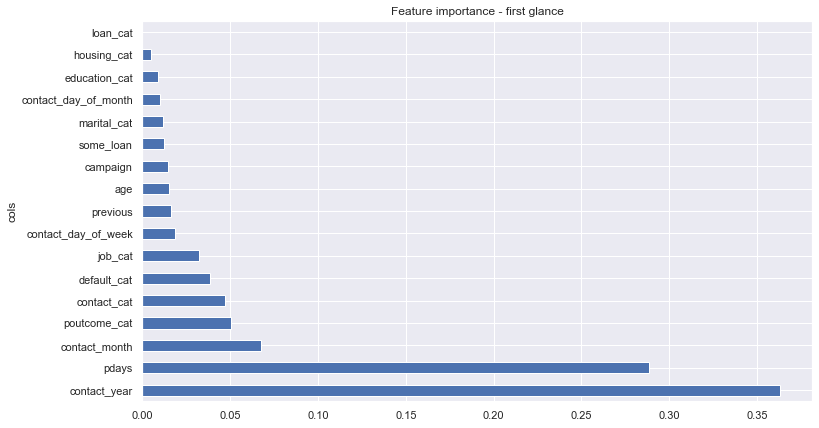

In [7]:
model = XGBClassifier()
model.fit(X, y)
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi, title=None): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, title=title)
fi = rf_feat_importance(model, X)
plot_fi(fi[:25], title="Feature importance - first glance")

* Rok kontaktu ma ogromne znaczenie - rzeczywiście dane są z okresu 2008-2010
    * 2008 - 0.049353617598742947
    * 2009 - 0.19854343679556094
    * 2010 - 0.527643064985451
    * Albo rolę gra kryzys finansowy, albo bank uczy się na swoich błędach i udoskonala swoje metody
* Ogromne znaczenie mają też dane na temat poprzedniej kampanii - pdays i poutcome
* Dalej ważne były kategorie o których myśleliśmy na począktu takie jak forma kontaktu, czy problemy ze spłatą kredytu, ponad to jeszcze zatrudnienie
* Co ciekawe ważny jest też w tym wszystkim miesiąc kontaktu

In [8]:
def count_yes_ratio(mask):
    data_subset = data[mask]
    yes = (data_subset.y == 'yes').sum()
    no = (data_subset.y == 'no').sum()
    return yes / (yes + no)

for year in range(2008, 2011):
    print(year, count_yes_ratio(data['contact_year'] == year))

2008 0.049353617598742947
2009 0.19854343679556094
2010 0.527643064985451


### Rzeczywisty początek drugiej pracy domowej

# Punkt 2.1 - wytrenowanie modelu GBM

In [9]:
model = XGBClassifier()
print('Cross validation score with 5 stratified folds is eval to {}'.format(cross_val_score(model, X, y, scoring='roc_auc', cv=cv).mean()))

Cross validation score with 5 stratified folds is eval to 0.7910322008921834


In [39]:
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Punkt 2.2 - for some selected observations (two or three) from this dataset, calculate predictions for model

Obliczam predykcje dla obserwacji ze zbioru treningowego, danych było 40 tysięcy obserwacji a to wydaje się być względnie duża liczba w przypadku modeli machine learningowych opartych na danych tabularycznych (z małą ilością cech) więc przyjmuję mały wpływ tego, że dana obserwacja była widziana przez model.

* Wylosowałem trzy przykłady, jeden z wylosowanych klientów skorzystał z oferty i założył lokatę, pozostała dwójka z nich nie.
* Predykcje modelu wyglądają okej, zgadzają się z rzeczywistymi labelami
* Policzyłem jeszcze z ciekawości do dalszej analizy prediction bias, i tutaj jest on dla Boostingu niemal zerowy

In [11]:
n_samples = 3
indexes = np.random.randint(low=0, high=X.shape[0], size=(n_samples))
sample_observations = X.iloc[indexes]
final_outcomes_from_sample_observations = y[indexes]
full_dataset[full_dataset['y'] != 'unknown'].reset_index().iloc[indexes].head(n=n_samples)

,index,id,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
15795,31222,31223,1971-06-13,blue-collar,married,basic.4y,no,no,no,2009-05-20,cellular,1,999,1,failure,no
860,1681,1682,1952-05-20,admin.,single,high.school,no,no,no,2008-05-23,telephone,2,999,0,nonexistent,no
5390,10665,10666,1973-05-02,services,single,high.school,unknown,yes,no,2008-06-24,telephone,2,999,0,nonexistent,no


In [12]:
model_predictions = model.predict_proba(sample_observations)
print(model_predictions)

[[0.9216459  0.07835409]
 [0.9586364  0.0413636 ]
 [0.956951   0.04304901]]


In [13]:
y_proba = model.predict_proba(X)
largest_true_probability_in_data = y_proba[:, 1].argmax()

print('Rzeczywista średnia w danych {}'.format(y.mean()))
print('Średni wynik naszego modelu {}'.format(y_proba[:, 1].mean()))

Rzeczywista średnia w danych 0.11442857829703351
Średni wynik naszego modelu 0.11448416113853455


# Punkt 2.3 - for observations selected in (2), calculate the decomposition of model prediction using SHAP

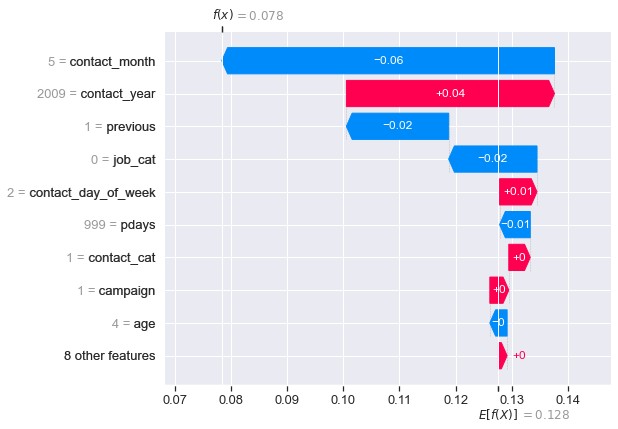

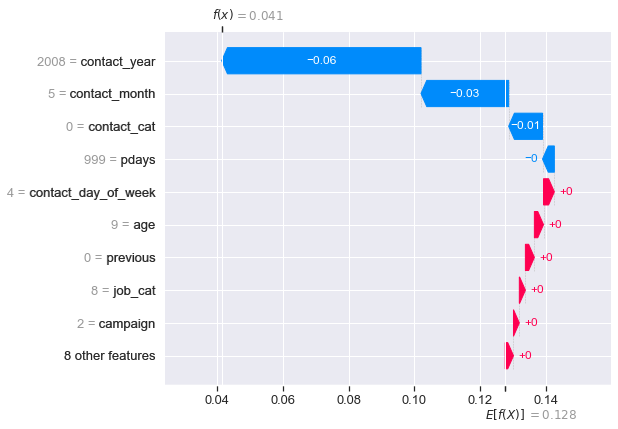

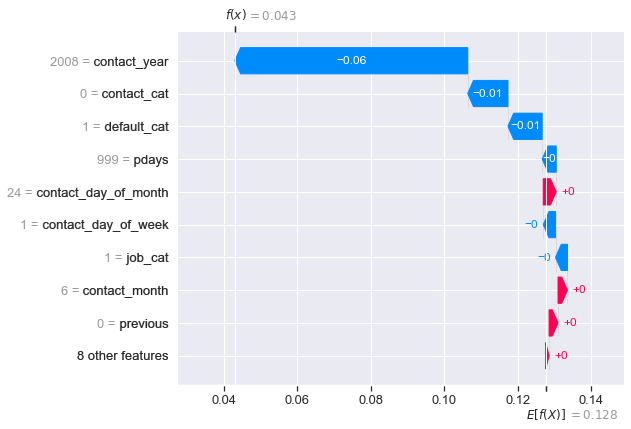

In [14]:
import shap
explainer = shap.TreeExplainer(model, X, model_output='probability')
shap_values = explainer(sample_observations)

for i in range(n_samples):
    shap.plots.waterfall(shap_values[i])

# Punkt 2.4 - Find two observations in the data set, such that they have different most important variables

Przeszukałem dataset i byłem w stanie znaleźć dwie obserwacje dla której jednym z dwóch najważniejszych parametrów nie byłby rok lub chociażby miesiąc, skupię się na dokładnym wyjaśnieniu jednej z nich.
Tak jak wcześniej zauważyłem, bank z roku na rok ma znaczący wzrost w skuteczności swoich działań marketingowych.

Załóżmy więc, że jedną z dwóch najważniejszych zmiennych nie jest rok i miesiąc

Według feature importance, ważny jest jeszcze pdays, przypominając jest to ilość dni od poprzedniego kontaktu z klientem, jeśli wartość nie jest 999 to bank się kontaktował z klientem. Teraz skoro decyduje zadzwonić do niego ponownie to pewnie dostał taką instrukcję od klienta który chce z bankiem rozmawiać, ale na przykład nie ma teraz czasu albo dzwoni żeby może dokończyć uzgadnianie warunków umowy. 
W każdym razie pdays nierówny 999 daje nam według danych 64% pewności na decyzję klienta na chęć założenia lokaty.

Patrząc jednak na resztę featurów, to choć mogą mieć one znaczenie (praca, status związkowy) to są zdefiniowane na tyle wysoko-poziomowo, że same w sobie nie są raczej w stanie wywrzeć dużego wpływu na predykcję. Jeszcze inne featury są bardzo skorelowane z pdays, jeśli pdays jest nie równe 999 to na przykład 90% klientów w poprzedniej kampanii korzystało z produktów banku czyli poutcome. Podobnie jest też z oczywiście z previous czyli liczbą poprzednich kontaktów.

Teraz dlaczego ostatecznie mi się udało znaleźć przykład - tak jak rozumiem liczenie Shap values, to mamy tutaj do czynienia z anomalią w danych.
Wszystko w podanym przykładzie wskazuje na to, że klient zdecyduje się na ofertę banku
* Średni wynik to 13%, a jednak w 2009 roku jest 20%
* Jeśli mamy pdays != 999 to mamy 64% szans
* Jeśli ma się previous > 1 to mamy 50% szans

* Ale w 2009 roku, dla previous = 4, mamy 4 przypadki z których nikt nie zdecydował się na lokatę.
* I tak jak inne cechy jak rok, pdays, miesiąc szybko podbiją prawdopodobieństwo tak potem previous je mocno obniży stąd ten przykład

In [15]:
alot_shap_values = explainer(X.iloc[:])
np.abs(alot_shap_values.values).argsort()[:, -2:]
for idx, x in enumerate(np.abs(alot_shap_values.values).argsort()[:, -2:]):
    if 5 not in x and 4 not in x:
        print(idx, x)

100%|===================| 20701/20799 [00:26<00:00]        

19098 [2 1]
20776 [1 2]


In [16]:
X.loc[19098:19098]

,campaign,pdays,previous,age,contact_year,contact_month,contact_day_of_month,contact_day_of_week,job_cat,marital_cat,education_cat,default_cat,housing_cat,loan_cat,contact_cat,poutcome_cat,some_loan
19098,1,6,4,0,2009,8,21,4,11,2,4,0,1,0,1,1,1


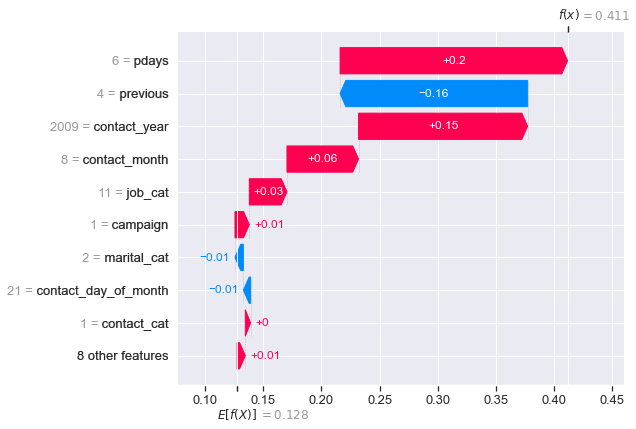

In [17]:
best_shap = explainer(X.loc[19098:19098+1]) 
shap.plots.waterfall(best_shap[0])

# Punkt 2.5 - Select one variable and find two observations in the data set such that for one observation this variable has a positive effect and for the other a negative effect

Z powodu już opisanych rozważań, contact_year w 2009 wskazuje na wartość oczekiwaną wyższą niż średnią, a wynik w 2008 na niższą niż średnia

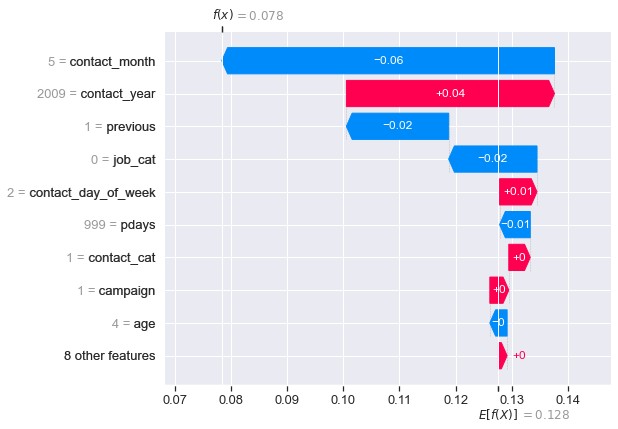

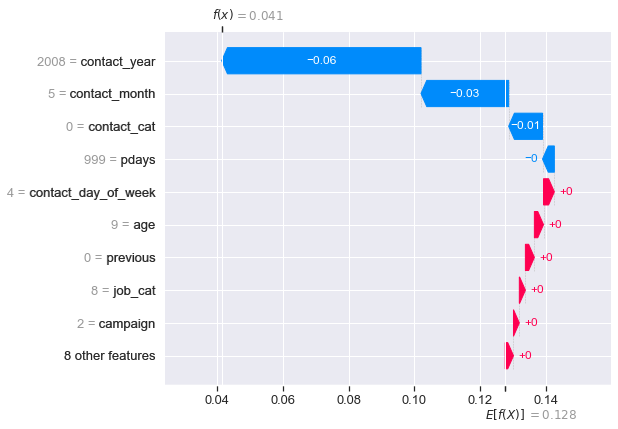

In [50]:
for i in range(2):
    shap.plots.waterfall(shap_values[i])

# Punkt 2.6 - Train a second model (of any class, neural nets, linear, other boosting) and find an observation for which BD/shap attributions are different between the models

Wytrenowałem znowu boosting classifier, ale z większą głebokością.
Różnice widać już po samym wykresie feature importance, tak jak było omawiane na zajęciach w drzewach losowych/boostingach dużo losujemy featurów w wierzchołkach i stosujemy wiele losowości, tak aby możliwie mocno różne drzewa patrzyły na inne rzeczy, były badziej niezależne i ulepszały wynik i zmniejszały wariancje. 

To sprawia, że w liściach mamy mniej przypadków, model bardziej overfituje do danych, przez co zmienne są ważniejsze i rozkład ważności zmiennych jest bardziej wyrównany.

<AxesSubplot:title={'center':'Feature importance - first glance'}, ylabel='cols'>

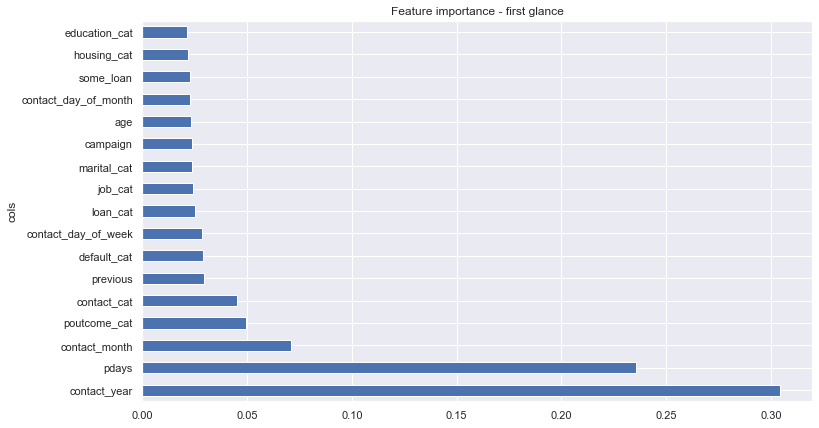

In [57]:
model = XGBClassifier(max_depth=7)
model.fit(X, y)
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
def plot_fi(fi, title=None): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False, title=title)
fi = rf_feat_importance(model, X)
plot_fi(fi[:25], title="Feature importance - first glance")

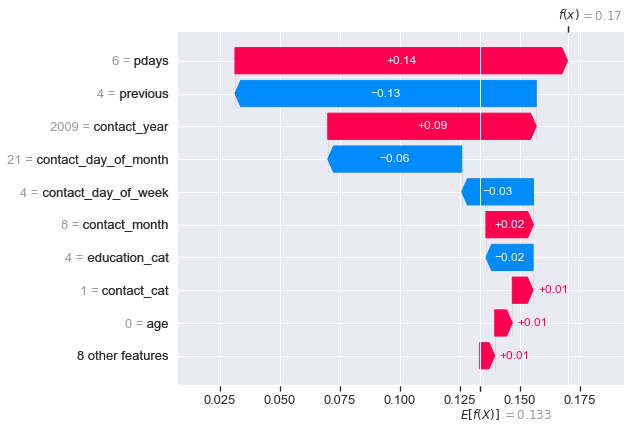

In [58]:
explainer = shap.TreeExplainer(model, X, model_output='probability')
best_shap = explainer(X.loc[19098:19098+1]) 
shap.plots.waterfall(best_shap[0])